In [1]:
# imports
%matplotlib inline
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

### Functions

In [2]:
def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array

def read_bin_files_to_array(folder_path):
    bin_files = []
    filenames = sorted(os.listdir(folder_path))
    for filename in filenames:
        if filename.endswith('.bin'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                data = np.fromfile(file, dtype=np.float32)
                bin_files.append(data)

    return bin_files


def split_images(image_array): 

    red_region_images = []
    raw_images = [] 

    for image in image_array:
        if image[25,100].sum() == 255*3 :
            red_region_images.append(image)
        else: 
            raw_images.append(image) 
            
    return red_region_images, raw_images

def split_train_val_test(images, masks):

    train_images = []
    train_masks = []
    val_images = []
    val_masks = []
    test_images = []
    test_masks = []

    for i in range(len(images)): 

    # these numbers are made specifically for this dataset 
        
        if i < 27: 
            train_images.append(images[i])
            train_masks.append(masks[i])
        elif i < 32:
            val_images.append(images[i])
            val_masks.append(masks[i])
        else: 
            test_images.append(images[i])
            test_masks.append(masks[i])

    return train_images, train_masks, val_images, val_masks, test_images, test_masks

def crop_raw_images(image_array): 
    
    cropped_images = [] 
    
    for i in range(len(image_array)): 
        
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (320, 240), 180, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

def crop_masks(image_array):
    cropped_images = []

    for i in range(len(image_array)): 
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (288, 307), 200, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

def add_padding(image_array, amt_x, amt_y): 
    
    padded_images = []
    
    for image in image_array: 

        padded_image = cv2.copyMakeBorder(
            image,
            amt_y,
            amt_y,
            amt_x,
            amt_x,
            cv2.BORDER_CONSTANT,
            value=(255,255,255)
        )
        
        padded_images.append(padded_image)
        
    return padded_images

def zoom_at(image_array, zoom, coord=None):
    
    zoomed_array = []
    
    for img in image_array: 
        
        h, w, _ = [ zoom * i for i in img.shape ]

        if coord is None: cx, cy = w/2, h/2
        else: cx, cy = [ zoom*c for c in coord ]

        img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
        img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
                   int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5)),
                   : ]
        zoomed_array.append(img)
    
    return zoomed_array


def create_binary_masks(image_array):
    binary_masks = []
    
    for image in image_array:
        # Ensure image is in BGR format (convert if necessary)
        if image.ndim == 2:
            # Convert grayscale to BGR color (assuming gray image)
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] != 3:
            raise ValueError("Input image must have 3 channels (BGR format).")
        else:
            image_color = image
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

        # Define lower and upper bounds for red color in HSV
        lower_red = np.array([0, 150, 115])
        upper_red = np.array([255, 255, 255])

        # Create mask using inRange function
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Apply bitwise AND operation using color image
        res = cv2.bitwise_and(image_color, image_color, mask=mask)
        
        binary_masks.append(mask)
        
    return binary_masks

def crop_images(image_array): 
    
    cropped_images = []
    
    for i in range(len(image_array) -1): 
        
        image = image_array[i]
        
        image_height, image_width = image.shape[:2]
        
        # Bounding box dimensions
        box_width, box_height = 256, 256

        x_top_left = (image_width - box_width) // 2
        y_top_left = (image_height - box_height) // 2
        x_bottom_right = x_top_left + box_width
        y_bottom_right = y_top_left + box_height
        
        cropped_image = image[y_top_left:y_bottom_right, x_top_left:x_bottom_right]
        cropped_images.append(cropped_image)
                              
    return cropped_images

### Apply Functions

In [4]:
images = read_images_to_array('../data/invotive_data/')
depth = read_images_to_array('../getting_depth_info/data/')
masks, raw = split_images(images)
og_red = masks
images = depth

train_images, train_masks, val_images, val_masks, test_images, test_masks = split_train_val_test(images, masks)

train_images = crop_raw_images(train_images)
train_images = add_padding(train_images, 0, 67)
train_images = crop_images(train_images)
train_masks = crop_masks(train_masks)
train_masks = add_padding(train_masks, 31, 0)
#train_masks = zoom_at(train_masks, 1.156, coord=None)
train_masks = create_binary_masks(train_masks)
train_masks = crop_images(train_masks)

val_images = crop_raw_images(val_images)
val_images = add_padding(val_images, 0, 67)
val_images = crop_images(val_images)
val_masks = crop_masks(val_masks)
val_masks = add_padding(val_masks, 31, 0)
#val_masks = zoom_at(val_masks, 1.156, coord=None)
val_masks = create_binary_masks(val_masks)
val_masks = crop_images(val_masks)

test_images = crop_raw_images(test_images)
test_images = add_padding(test_images, 0, 67)
test_images = crop_images(test_images)
test_masks = crop_masks(test_masks)
test_masks = add_padding(test_masks, 31, 0)
#test_masks = zoom_at(test_masks, 1.156, coord=None)
test_masks = create_binary_masks(test_masks)
test_masks = crop_images(test_masks)

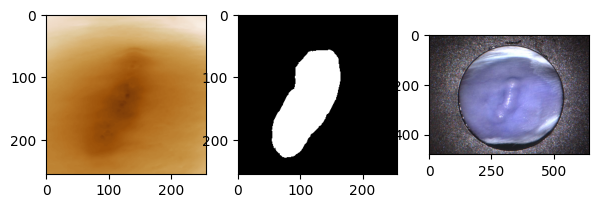

In [13]:
# sanity check 

rand = random.randint(0, len(train_images) -1)

fig, ax = plt.subplots(1,3, figsize=[7,7])

ax[0].imshow(train_images[rand])
ax[1].imshow(train_masks[rand], cmap="gray")
ax[2].imshow(raw[rand])

### Augmentation

In [14]:
def augment_image_array(image_array_raw, image_array_binary, num_augmentations):
    
    aug_raw = []
    aug_masks = []
    
    for _ in range(num_augmentations):
            for i in range(len(image_array_raw) -1):
                image_raw = image_array_raw[i]
                image_binary = image_array_binary[i]

                flipped_image_raw = cv2.flip(image_raw, 1)
                flipped_image_binary = cv2.flip(image_binary, 1)

                angle = random.uniform(-30, 30)
                (h, w) = flipped_image_raw.shape[:2]
                center = (w // 2, h // 2)

                M = cv2.getRotationMatrix2D(center, angle, 1.0)
                augmented_image_raw = cv2.warpAffine(flipped_image_raw, M, (w, h))
                augmented_image_binary = cv2.warpAffine(flipped_image_binary, M, (w, h))

                aug_raw.append(augmented_image_raw)
                aug_masks.append(augmented_image_binary)

    image_array_raw = np.concatenate((image_array_raw, np.array(aug_raw)))
    image_array_binary = np.concatenate((image_array_binary, np.array(aug_masks)))

    return image_array_raw, image_array_binary

In [15]:
# apply augmentation to arrays 

train_images, train_masks = augment_image_array(train_images, train_masks, 500)
val_images, val_masks = augment_image_array(val_images, val_masks, 500)
test_images, test_masks = augment_image_array(test_images, test_masks, 50)

In [16]:
# print new lengths 

print(len(train_images))
print(len(val_images))
print(len(test_images))

12526
1504
52


### Create the Dataset

In [ ]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
training_dataset_dict = {
    "image": [Image.fromarray(img) for img in train_images],
    "label": [Image.fromarray(mask) for mask in train_masks],
}

val_dataset_dict = {
    "image": [Image.fromarray(img) for img in val_images],
    "label": [Image.fromarray(mask) for mask in val_masks],
}

In [ ]:
# Create the dataset using the datasets.Dataset class
training_dataset = Dataset.from_dict(training_dataset_dict)
val_dataset = Dataset.from_dict(val_dataset_dict)

In [17]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

from torch.utils.data import random_split, DataLoader

training_dataset = SAMDataset(dataset=training_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)


train_dataloader = DataLoader(dataset=training_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False) 

from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

    from torch.optim import Adam
import monai

### Training

In [ ]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []

    # Training loop
    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Logging training results
    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean(epoch_losses)}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_losses = []
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(val_dataloader):
            # Forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            # Compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            val_losses.append(loss.item())

    # Logging validation results
    print(f'Mean validation loss: {mean(val_losses)}')
    
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "./models/mito_model_checkpoint6.pth")